In [444]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import namedtuple
from pathlib import Path
import os
Cluster = namedtuple('Point', 'x y z')#meant to convey x,y,z mean of cluster
#repopath = Path(__file__).parent
# fname = r'D:\ObstacleSegmentation\1636310276 - 4-3877 ms.txt'
#fname = r'1636310276 - 4-3877 ms.txt'
fname = r'1636468456 - 1-4789 ms.txt'
#file = os.path.join(repopath,fname)
#output = os.path.join(repopath,'beta_angles_' + fname)

#create pandas dataframe from asc file
df = pd.read_csv(fname,header=None,delimiter = ' ')

#rename the columns based on output from cloudcompare 
#df.columns =['x','y','z', 'dist','ang','time','r','g','b','empty']
df.columns = ['x', 'y', 'z', 'r', 'g', 'b', 'dist','ang', 'time']
#df = pd.read_csv('D:/ObstacleSegmentation/1636310276.7642572_LidarSensor1_pointcloud.asc')
npdf = df[['x','y','z']].to_numpy()

In [445]:
LIDAR_range=100
elevation_angle=(30*np.pi)/180
number_beams=16
raster_buffer=1.25 #25%
distance_between_raster_lines=LIDAR_range*np.tan(elevation_angle / number_beams)*raster_buffer

In [446]:
clustering = DBSCAN(.5, min_samples=2).fit(npdf)

In [447]:
df['clusterfromdbscan'] = clustering.labels_ #add clusterfromdbscan column to df

In [448]:
cluster_centers=dict.fromkeys(df.clusterfromdbscan.unique())
for cluster in df.clusterfromdbscan.unique():  
    tempclusterseries = df[df['clusterfromdbscan']==cluster][['x', 'y', 'z']].agg('mean') #grabs all points associated with cluster in for loop step
    
    cluster_centers[cluster]= Cluster(tempclusterseries.x,tempclusterseries.y,tempclusterseries.z) #makes cluster series type into dict, 'cluster_centers.x,...'

(array([48091.,  2808.,  1649.,  6958.,  1138.,  1635.,  2416.,  2281.,
         1098.,   603.]),
 array([ 0. ,  8.9, 17.8, 26.7, 35.6, 44.5, 53.4, 62.3, 71.2, 80.1, 89. ]),
 <BarContainer object of 10 artists>)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
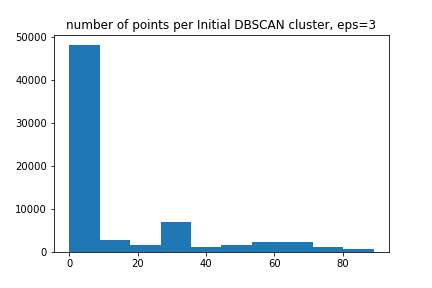

In [449]:
%matplotlib widget
plt.title('number of points per Initial DBSCAN cluster, eps=3')
plt.hist(clustering.labels_)

In [450]:
df['clusterfromdbscan'] = clustering.labels_
dfsample = df[df.clusterfromdbscan < 25]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
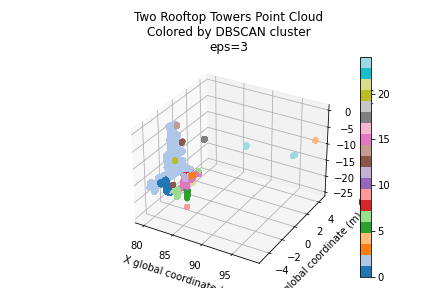

In [451]:
%matplotlib widget
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
ax3D.set_zlabel('Z global coordinate (m)')
p = ax3D.scatter(dfsample.x,dfsample.y,dfsample.z,c = dfsample.clusterfromdbscan,cmap = plt.get_cmap("tab20"))
# plt.suptitle("Two Rooftop Towers Point Cloud")
plt.title("Two Rooftop Towers Point Cloud\nColored by DBSCAN cluster\neps=3")
plt.xlabel('X global coordinate (m)')
plt.ylabel('Y global coordinate (m)')
plt.tight_layout()
fig.colorbar(p,ax=ax3D)

In [452]:
#Associate clusters by neighborhood
cluster_center_array=pd.DataFrame.from_dict(cluster_centers,orient='index').to_numpy()

In [453]:
df[df['clusterfromdbscan']==cluster].describe()

,x,y,z,r,g,b,dist,ang,time,clusterfromdbscan
count,44.000000,44.000000,44.000000,44.0,44.0,44.0,44.000000,44.000000,44.000000,44.0
mean,101.908524,4.378951,-9.373247,255.0,255.0,0.0,97.943394,0.003265,4766.954545,89.0
std,0.030207,0.052740,0.000054,0.0,0.0,0.0,0.027818,0.000140,12.858722,0.0
min,101.878662,4.326814,-9.373300,255.0,255.0,0.0,97.915894,0.003037,4745.000000,89.0
25%,101.878662,4.326814,-9.373300,255.0,255.0,0.0,97.915894,0.003133,4756.000000,89.0
50%,101.908524,4.378951,-9.373247,255.0,255.0,0.0,97.943394,0.003264,4767.000000,89.0
75%,101.938385,4.431088,-9.373194,255.0,255.0,0.0,97.970894,0.003396,4778.000000,89.0
max,101.938385,4.431088,-9.373194,255.0,255.0,0.0,97.970894,0.003497,4788.000000,89.0


In [454]:
def specialangle(d0, theta0, d1, theta1):
    psi = np.abs(theta0 - theta1)
    num = d0 * np.sin(psi)
    den = (d0 - d1) * np.cos(psi)
    beta = np.arctan2(num,den)
    return beta

In [455]:
def find_meanAngDist(thiscluster):
    mean_dist = thiscluster.dist.mean()
    mean_ang = thiscluster.ang.mean()
    x_center = thiscluster.x.mean()
    y_center = thiscluster.y.mean()
    z_center = thiscluster.z.mean()
    return mean_dist, mean_ang, x_center, y_center, z_center

In [456]:
cluster_median=dict.fromkeys(df.clusterfromdbscan.unique())
for cluster in df.clusterfromdbscan.unique():  
    [dist, ang, x, y, z] = find_meanAngDist(df[df['clusterfromdbscan']==cluster]) #grabs all points associated with cluster in for loop step
    cluster_median[cluster]= [dist, ang, x, y, z]

In [457]:
cluster_mean_array=pd.DataFrame.from_dict(cluster_median,orient='index')
cluster_mean_array.columns=['dist','ang', 'x', 'y', 'z']
cluster_mean_array

,dist,ang,x,y,z
0,81.541907,0.012233,81.905725,-3.364522,-19.091908
1,80.193611,0.028367,82.010039,-4.025491,-15.287149
2,79.766904,0.031976,81.340314,-2.553205,-11.374105
3,84.141535,0.001356,83.514283,-1.473057,-16.398145
4,98.334145,0.023700,98.053956,4.378342,-8.502248
...,...,...,...,...,...
85,99.169266,0.005272,103.090332,3.082546,-9.311580
86,99.983093,0.003254,102.425064,3.751647,-26.736063
87,99.626587,0.003254,102.091278,3.263652,-26.673571
88,89.543137,0.003259,93.527328,1.835336,-12.483469


In [458]:
#return beta for each pair of clusters
ptlist = cluster_mean_array.index.to_list()
betadict = dict.fromkeys(ptlist) #dictionary for placeholder for everypoint
for idx1,pt1 in cluster_mean_array.iterrows(): #take current index
    betadict[idx1] = dict.fromkeys(ptlist) #make nested dictionary for every point (point 1 to every other one)
    for idx2,pt2 in cluster_mean_array.iterrows(): #looping thrugh every row, iterrrows returns row number and corresponding data
        betadict[idx1][idx2] = specialangle(pt1.dist, pt1.ang, pt2.dist, pt2.ang)

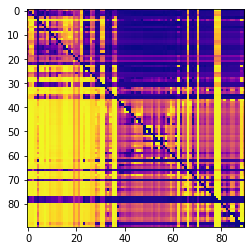

In [459]:
%matplotlib inline
data=pd.DataFrame(betadict).to_numpy()
plt.imshow(data, cmap='plasma', interpolation='nearest')

In [460]:
beta_bottom_thresh=np.deg2rad(30)
beta_top_thresh=np.deg2rad(60)
closepointsdict = dict.fromkeys(ptlist) #use index to generate the keys
for point in betadict.keys(): #getting the keys to loop through every point
    ptsinrange = []
    for point2, beta in betadict[point].items(): #getting back point and associated overlap for every entry
        if beta > beta_bottom_thresh and beta < beta_top_thresh:
            ptsinrange.append(point2) #append to ptsinrange
    closepointsdict[point] = ptsinrange

In [461]:
def getadjacent(confirmedhits,pt2check,need2checkstill):
    # current code requires set to be closed (e.g. dictionary must not reference points that aren't in dictionary
    # if pt2check in testdict: 
    need2checkstill = need2checkstill | (set(closepointsdict[pt2check]) - confirmedhits) #union is operator look up closedpointsdict for the point to check 
    if len(need2checkstill) > 0:
        thispt = need2checkstill.pop()
        confirmedhits = confirmedhits | set([thispt]) #union is grouping everything together
        return getadjacent(confirmedhits,thispt,need2checkstill)
    else:
        return confirmedhits

In [462]:
groupnum = 0
ungroupedpts = ptlist
print(ungroupedpts)
clusters_dict = {}
while len(ungroupedpts) > 0:
    adjacent_confirmed = set()
    need2checkstill = set()
    neighbors = getadjacent(adjacent_confirmed,ungroupedpts[0],need2checkstill)
    clusters_dict[groupnum] = neighbors
    if len(neighbors)==0:
        neighbors = [ungroupedpts[0]]
    print(neighbors)
    ungroupedpts = list(set(ungroupedpts) - set(neighbors))
    del ungroupedpts[0]
    print(ungroupedpts)
    groupnum+=1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
{1, 2, 66, 70, 77, 78, 79, 16, 22}
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
{1, 2, 66, 36, 70, 8, 77, 78, 15, 16, 17, 18, 79, 22, 30, 31}
[4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75

<BarContainer object of 38 artists>

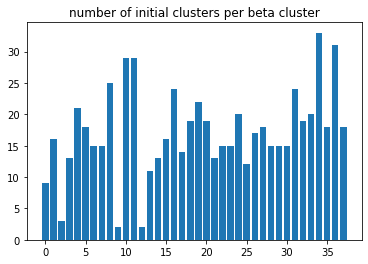

In [463]:
%matplotlib inline
plt.title('number of initial clusters per beta cluster')
plt.bar(clusters_dict.keys(),[len(v) for k,v in clusters_dict.items()])

In [464]:
reversedclusterdict = {}
for k,v in clusters_dict.items():
    for val in v:
        reversedclusterdict[val] = k

cluster_mean_array['betacluster']=cluster_mean_array.index.map(reversedclusterdict)
cluster_mean_array

,dist,ang,x,y,z,betacluster
0,81.541907,0.012233,81.905725,-3.364522,-19.091908,36.0
1,80.193611,0.028367,82.010039,-4.025491,-15.287149,36.0
2,79.766904,0.031976,81.340314,-2.553205,-11.374105,36.0
3,84.141535,0.001356,83.514283,-1.473057,-16.398145,36.0
4,98.334145,0.023700,98.053956,4.378342,-8.502248,37.0
...,...,...,...,...,...,...
85,99.169266,0.005272,103.090332,3.082546,-9.311580,32.0
86,99.983093,0.003254,102.425064,3.751647,-26.736063,NaN
87,99.626587,0.003254,102.091278,3.263652,-26.673571,32.0
88,89.543137,0.003259,93.527328,1.835336,-12.483469,NaN


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
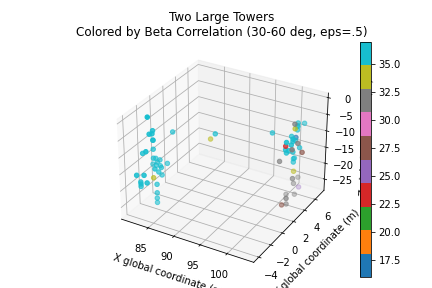

In [468]:
%matplotlib widget
fig = plt.figure()
ax3D = fig.add_subplot(111, projection='3d')
ax3D.set_zlabel('Z global coordinate (m)')
#p = ax3D.scatter(df.x,df.y,df.z)#original points colored by neighborhood, removed "",c = df.newcluster,cmap = plt.get_cmap("plasma")""
p = ax3D.scatter( cluster_mean_array.x,cluster_mean_array.y,cluster_mean_array.z,c = cluster_mean_array.betacluster,cmap = plt.get_cmap("tab10"))
# plt.suptitle("Two Rooftop Towers Point Cloud")
plt.title("Two Large Towers\nColored by Beta Correlation (30-60 deg, eps=.5)")
plt.xlabel('X global coordinate (m)')
plt.ylabel('Y global coordinate (m)')
plt.tight_layout()
fig.colorbar(p,ax=ax3D)

In [466]:
old2newclustermap = cluster_mean_array.betacluster.to_dict()
df['betacluster'] = df['clusterfromdbscan'].map(old2newclustermap)
df.to_csv(os.path.join(fname + '4050BetaAlgo.csv'))